In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv('monthly_prices.csv')

In [46]:
df.head()

,Date,price
0,2020-01,47001
1,2020-02,70609
2,2020-03,173928
3,2020-04,182180
4,2020-05,178814


In [47]:
df.tail()

,Date,price
19,2021-08,148853
20,2021-09,144979
21,2021-10,127395
22,2021-11,156685
23,2021-12,180000


In [48]:
df.shape

(24, 2)

In [49]:
print(f"Date range of quantity from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of quantity from - 2020-01 to 2021-12


In [50]:
print(f"Date range of quantity from {df.loc[:,'Date'][0]} to {df.loc[0:,'Date'][len(df)-1]}")

Date range of quantity from 2020-01 to 2021-12


In [51]:
date = pd.date_range(start = '1/1/2020', end='1/12/2022', freq='M')
date

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')

In [52]:
print(date)

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')


In [53]:
df['month']=date
df.drop('Date', axis =1, inplace= True)
df = df.set_index('month')
df.head()

,price
month,
2020-01-31,47001
2020-02-29,70609
2020-03-31,173928
2020-04-30,182180
2020-05-31,178814


# Step 1. EDA(Exploratory Data Analysis)

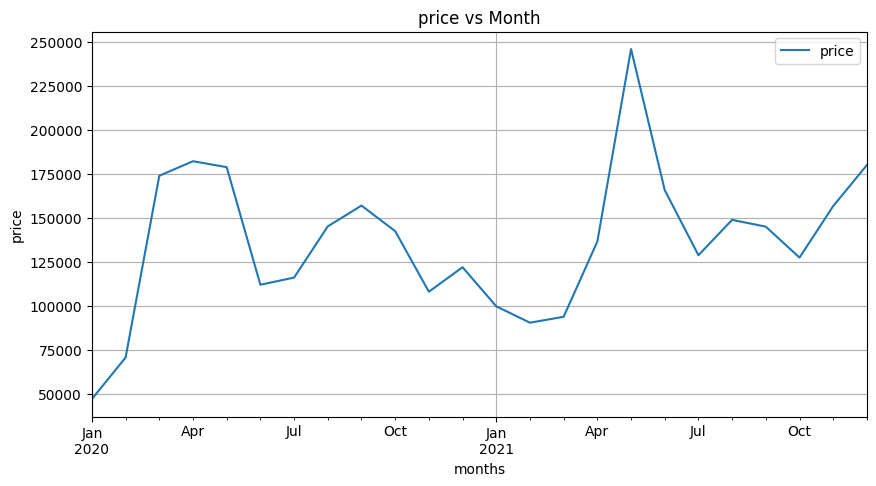

In [54]:
df.plot(figsize=(10,5))
plt.title("price vs Month")
plt.xlabel("months")
plt.ylabel("price")
plt.grid()

In [55]:
round(df.describe())

,price
count,24.0
mean,136407.0
std,42230.0
min,47001.0
25%,110974.0
50%,139486.0
75%,159177.0
max,245964.0


In [56]:
round(df.describe(),3)

,price
count,24.000
mean,136406.792
std,42230.185
min,47001.000
25%,110973.500
50%,139485.500
75%,159177.250
max,245964.000


In [57]:
from statsmodels.graphics.tsaplots import month_plot

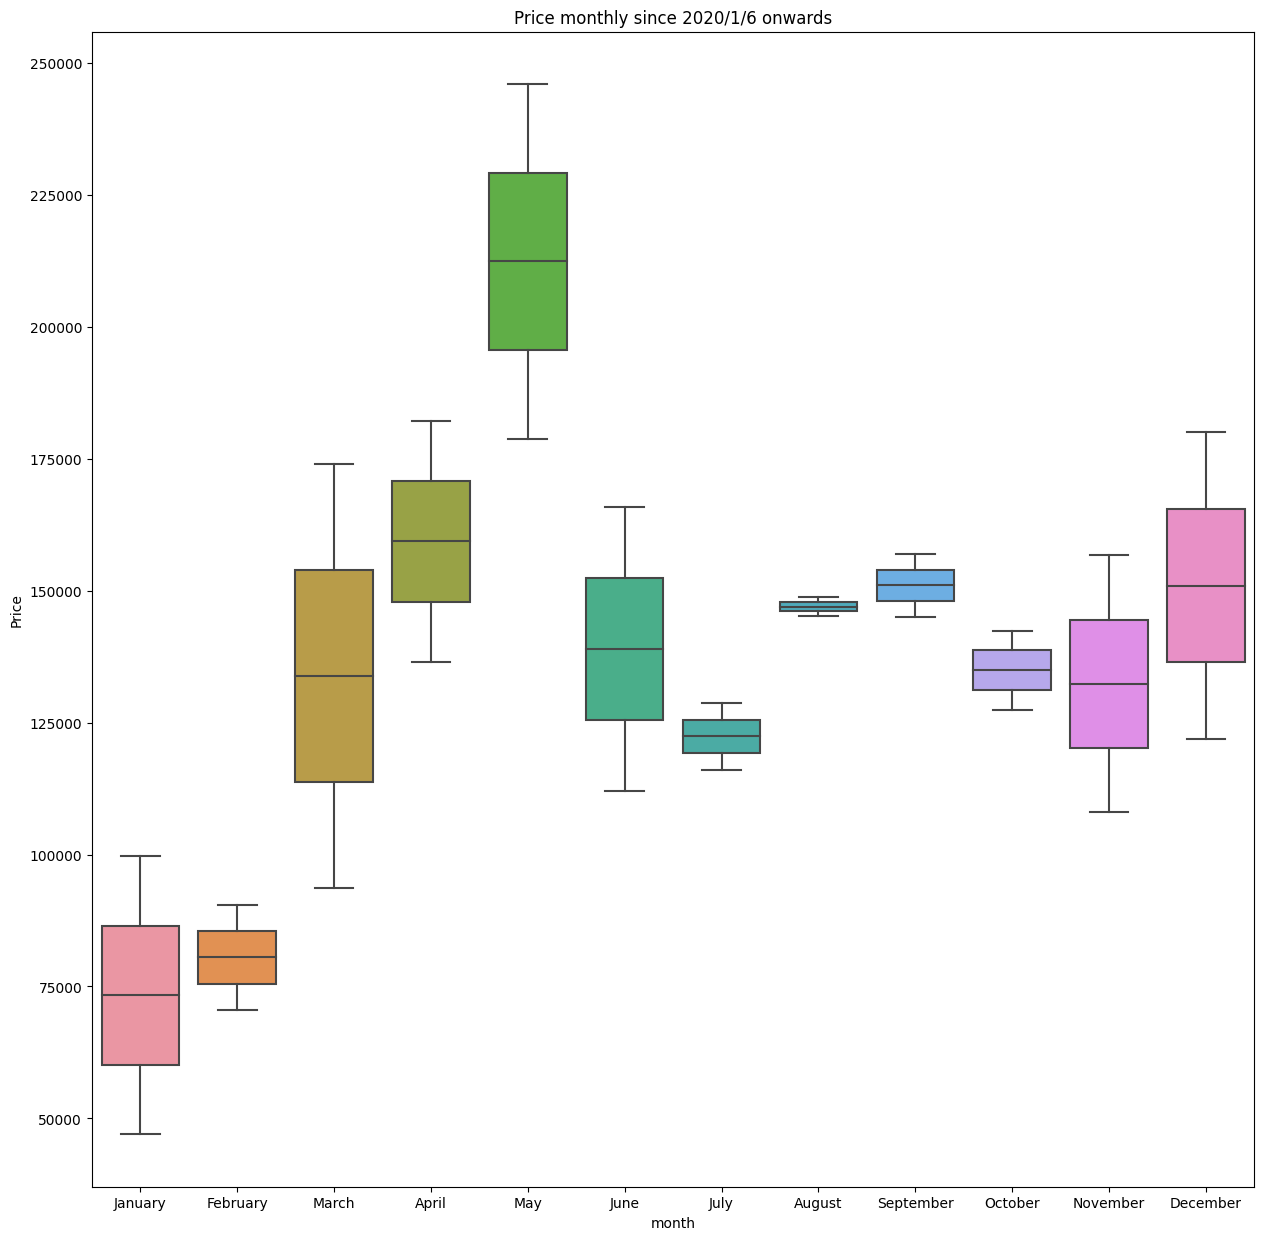

In [58]:
_, ax = plt.subplots(figsize=(15,15))
sns.boxplot(x = df.index.month_name(), y = df.values[:, 0], ax=ax)
plt.title("Price monthly since 2020/1/6 onwards")
plt.xlabel("month")
plt.ylabel("Price")
plt.show();

                    price
month                    
2020-12-31  129584.083333
2021-12-31  143229.500000


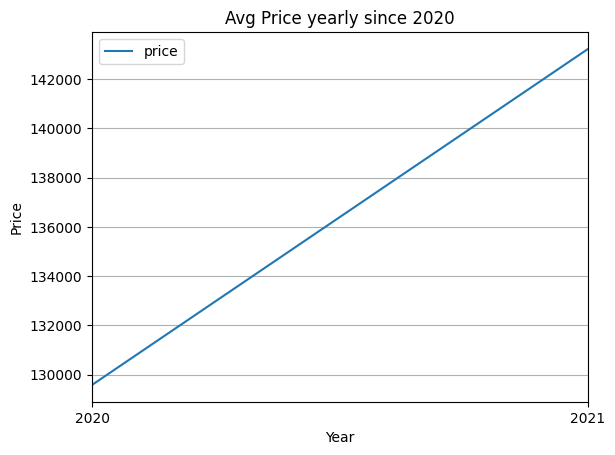

In [59]:
df_yearly_sum = df.resample('Y').mean()
print(df_yearly_sum)
df_yearly_sum.plot();
plt.title("Avg Price yearly since 2020")
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid();

                    price
month                    
2020-03-31   97179.333333
2020-06-30  157651.666667
2020-09-30  139383.333333
2020-12-31  124122.000000
2021-03-31   94613.000000
2021-06-30  182753.666667
2021-09-30  140858.000000
2021-12-31  154693.333333


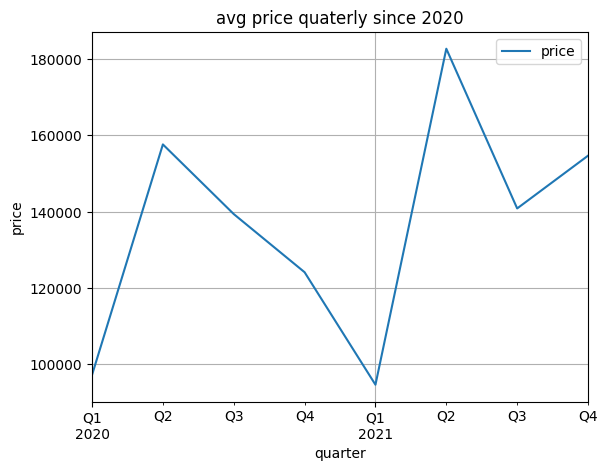

In [60]:
df_quarterly_sum = df.resample('Q').mean()
print(df_quarterly_sum)
df_quarterly_sum.plot();
plt.title("avg price quaterly since 2020")
plt.xlabel('quarter')
plt.ylabel('price')
plt.grid();

# Step 2. Analysis in coeffient of variation. CV means coeffient of variation in prices.

In [61]:
df_1 = df.groupby(df.index.month).mean().rename(columns= {'price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.month).std().rename(columns={'price':'Std'}),left_index= True, right_index= True)
df_1['Cov_pct']=((df_1['Std']/df_1["Mean"])*100).round(2) #coefficient of variation (CV) expressed as a percentage
df_1.head()

,Mean,Std,Cov_pct
month,,,
1,73351.0,37264.527369,50.80
2,80498.0,13985.157918,17.37
3,133839.5,56693.700395,42.36
4,159355.5,32278.717454,20.26
5,212389.0,47482.220357,22.36


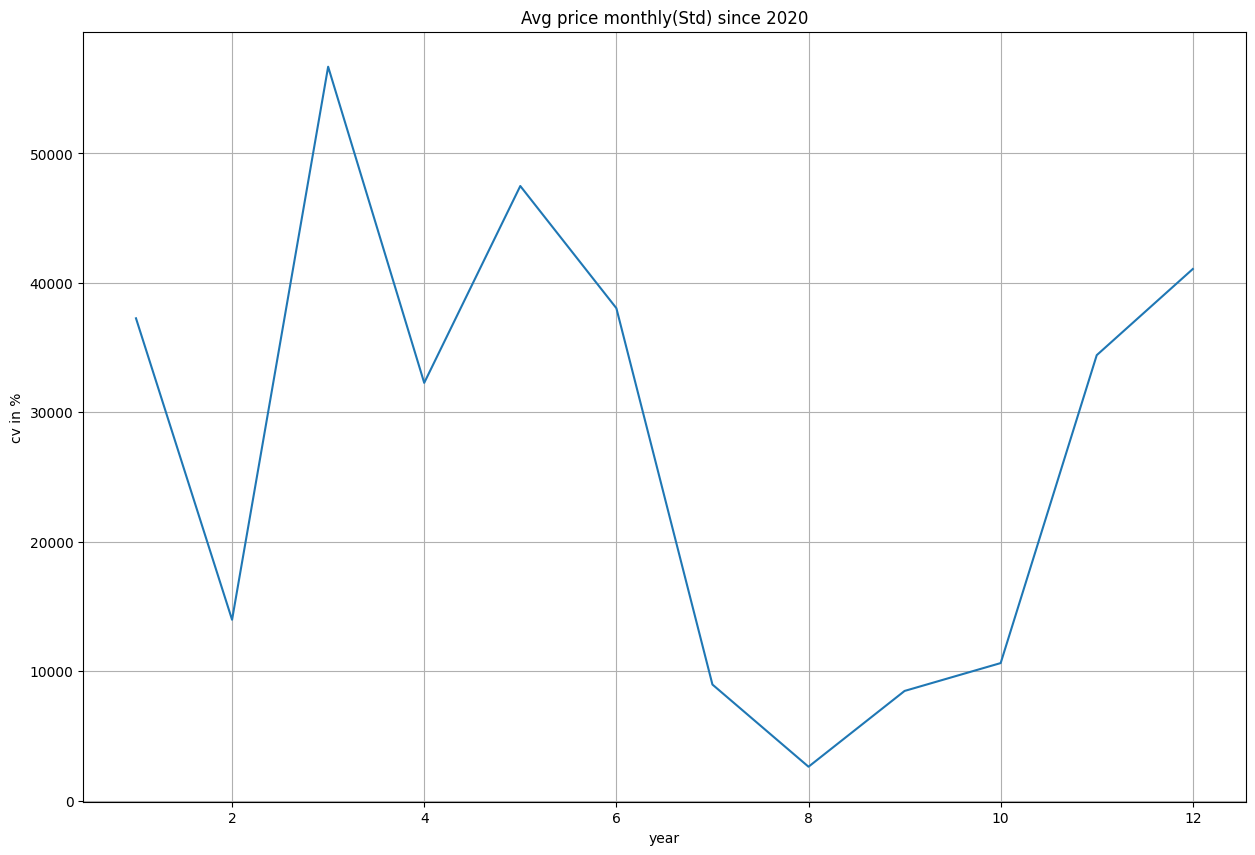

In [62]:
fig, ax = plt.subplots(figsize= (15,10))
df_1['Std'].plot();
plt.title("Avg price monthly(Std) since 2020") #coefficient of variation (CV) expressed as a percentage
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()

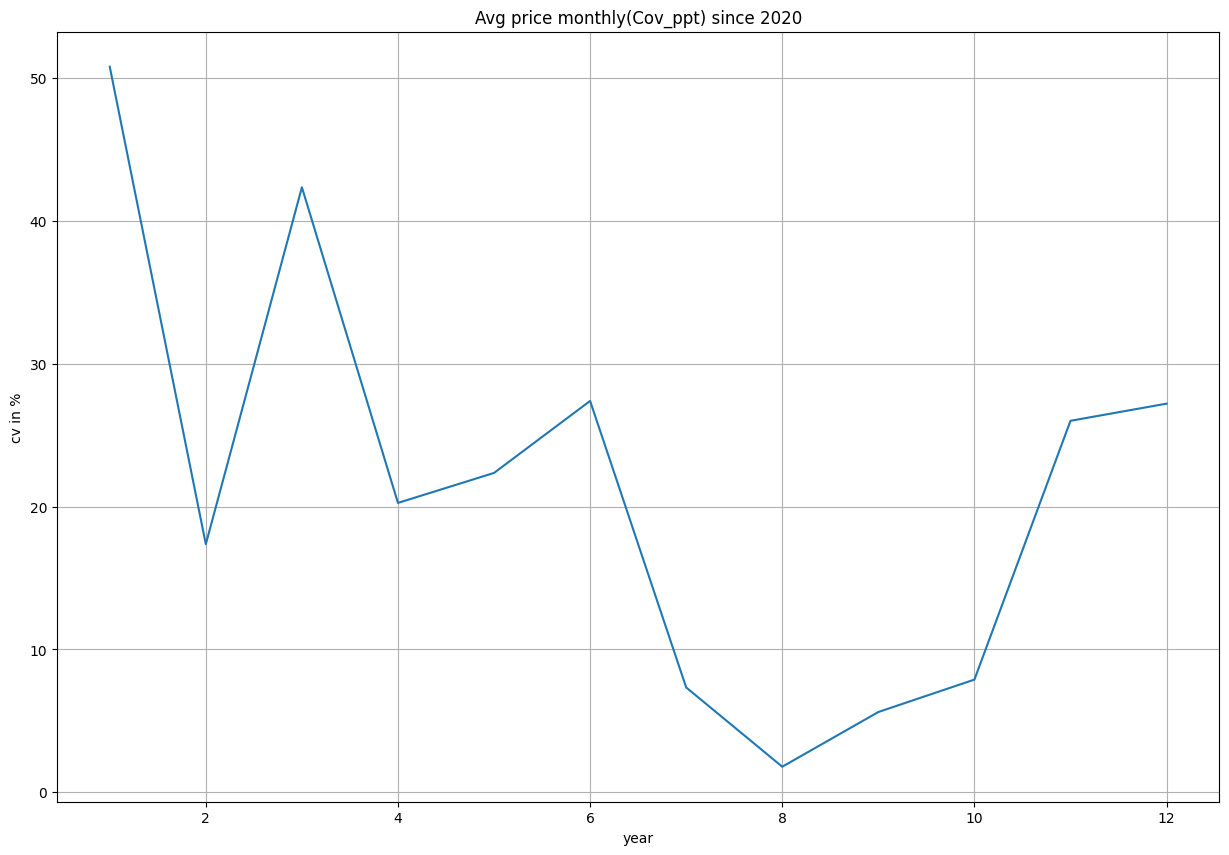

In [63]:
fig, ax = plt.subplots(figsize= (15,10))
df_1['Cov_pct'].plot();
plt.title("Avg price monthly(Cov_ppt) since 2020") #coefficient of variation (CV) expressed as a percentage
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()

# Step3.1: Time Series Forecasting

In [64]:
train = df[df.index <= "6/30/2021"]
test = df[df.index >= "6/30/2021"]

In [65]:
print(train)
print(test)

             price
month             
2020-01-31   47001
2020-02-29   70609
2020-03-31  173928
2020-04-30  182180
2020-05-31  178814
2020-06-30  111961
2020-07-31  116041
2020-08-31  145128
2020-09-30  156981
2020-10-31  142440
2020-11-30  108011
2020-12-31  121915
2021-01-31   99701
2021-02-28   90387
2021-03-31   93751
2021-04-30  136531
2021-05-31  245964
2021-06-30  165766
             price
month             
2021-06-30  165766
2021-07-31  128742
2021-08-31  148853
2021-09-30  144979
2021-10-31  127395
2021-11-30  156685
2021-12-31  180000


In [66]:
print(train.shape)
print(test.shape)

(18, 1)
(7, 1)


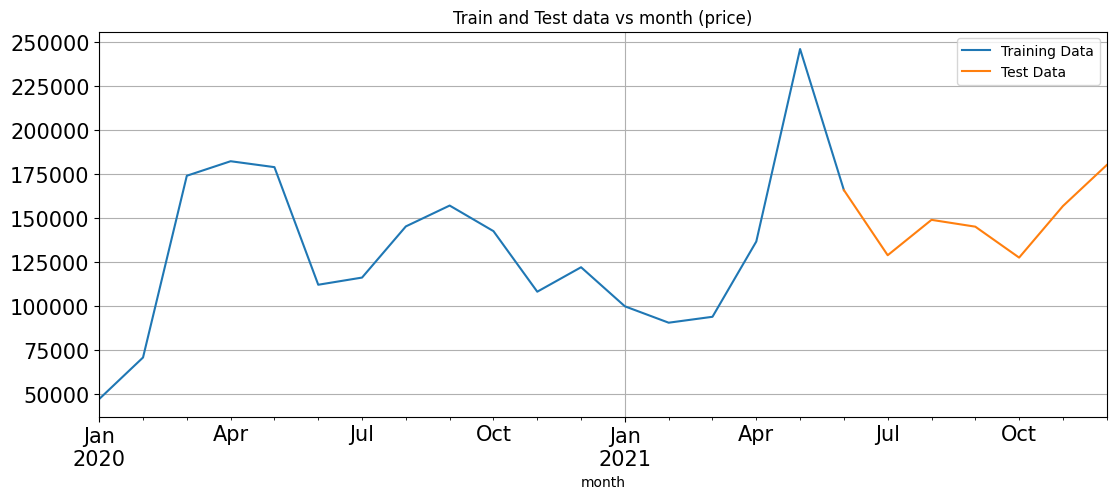

In [67]:
train["price"].plot(figsize=(13,5), fontsize =15)
test["price"].plot(figsize=(13,5), fontsize = 15)
plt.title("Train and Test data vs month (price)")
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

# Step 3.2: Moving forward let's do model formation now.

# A. Linear Regression

In [68]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(18, 7)

In [69]:
LR_train = train.copy()
LR_test = test.copy()

In [70]:
LR_train['time']= train_time
LR_test['time']= test_time

In [76]:
from sklearn.linear_model import LinearRegression

# Create a LinearRegression object
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train["price"].values)


LinearRegression()

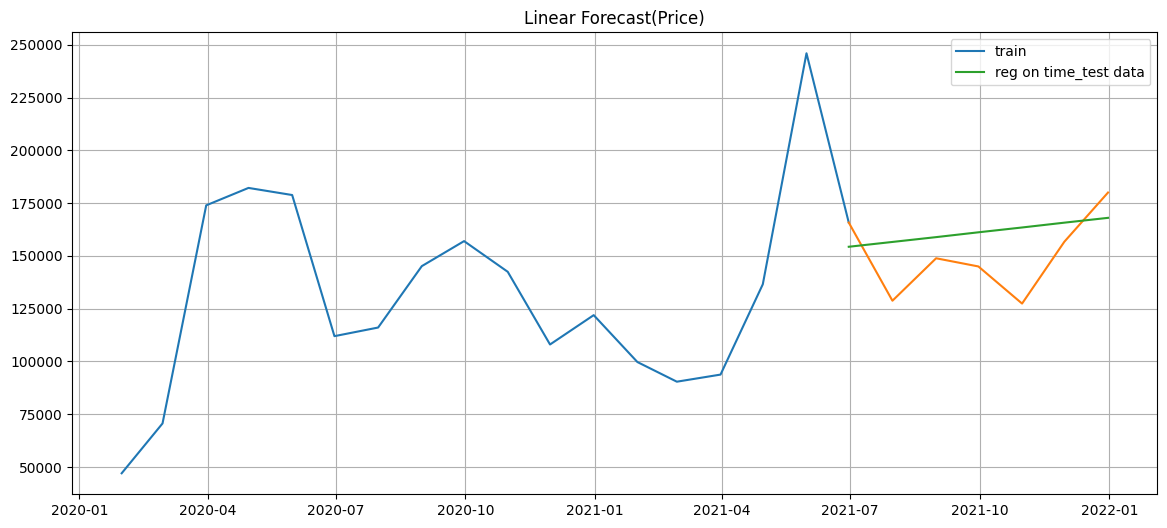

In [77]:
test_predictions_model1 = lr.predict(LR_test[["time"]])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize = (14,6))
plt.plot(train["price"], label = 'train')
plt.plot(test["price"])
plt.plot(LR_test['forecast'], label = 'reg on time_test data')
plt.title("Linear Forecast(Price)")
plt.legend(loc = 'best')
plt.grid();

In [78]:
def mape(actual, pred): 
    return round((np.mean(abs(actual - pred)/actual))*100,2)

In [79]:
mape_model1_test = mape(test['price'].values,test_predictions_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 12.450 %


In [80]:
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,12.45


# B. Naive Regression

In [81]:
Naive_train = train.copy()
Naive_test = test.copy()

In [82]:
Naive_test['naive']= np.asarray(train['price'])[len(np.asarray(train['price']))-1]
Naive_test['naive'].head()

month
2021-06-30    165766
2021-07-31    165766
2021-08-31    165766
2021-09-30    165766
2021-10-31    165766
Name: naive, dtype: int64

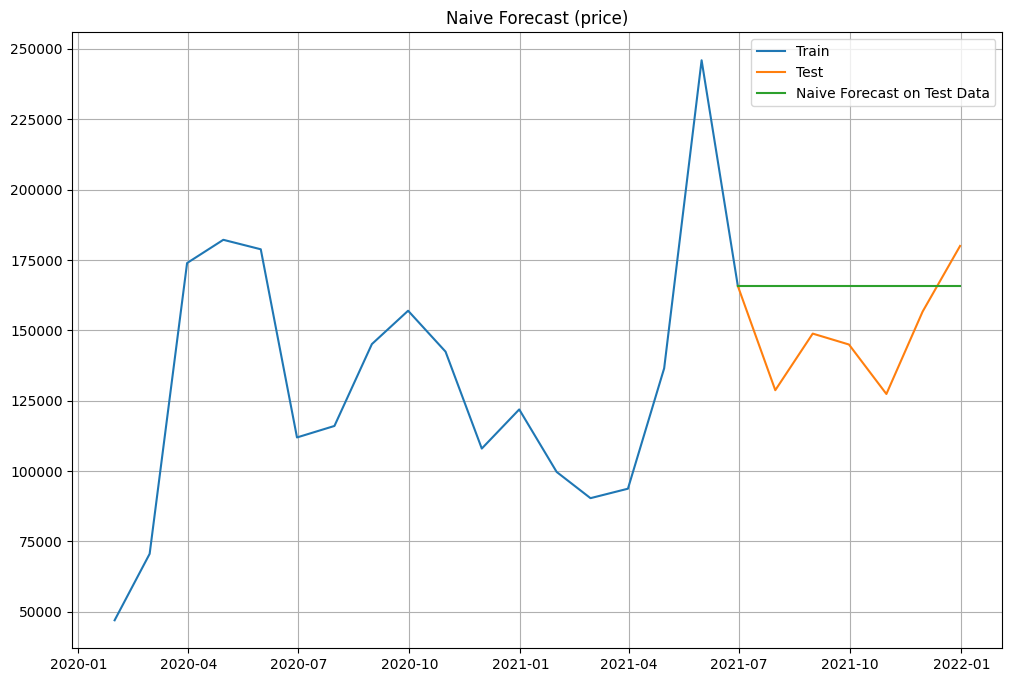

In [83]:
plt.figure(figsize = (12,8))
plt.plot(Naive_train["price"], label = 'Train')
plt.plot(test["price"], label = 'Test')
plt.plot(Naive_test['naive'], label = 'Naive Forecast on Test Data')
plt.legend(loc = 'best')
plt.title("Naive Forecast (price)")
plt.grid();

In [84]:
mape_model2_test = mape(test['price'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data ,MAPE is %3.3f" %(mape_model1_test),"%")

For Naive forecast on the Test Data ,MAPE is 12.450 %


In [85]:
resultsDf_2 = pd.DataFrame({'Test Mape (%)': [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results,resultsDf_2])
results

,Test Mape (%)
RegressionOnTime,12.45
NaiveModel,14.04


# C. ExpnentialSmoothing

In [86]:
exponentialSmoothing = ExponentialSmoothing(df,
                                trend = 'additive',
                                seasonal = 'additive').fit(smoothing_level = 0.9,
                                                          smoothing_trend= 0.9,
                                                          smoothing_seasonal = 0.9)



In [87]:
Mape_expexponentialSmoothing = mape(df['price'].values, exponentialSmoothing.fittedvalues)

In [88]:
print("MAPE:", Mape_expexponentialSmoothing) # Mean absolute percentage error (MAPE)

MAPE: 12.47


In [89]:
resultsDf_2 = pd.DataFrame({'Test Mape (%)': [Mape_expexponentialSmoothing]}, index=['exponentialSmoothing'])
results = pd.concat([results,resultsDf_2])
results

,Test Mape (%)
RegressionOnTime,12.45
NaiveModel,14.04
exponentialSmoothing,12.47


# Step 4: Final Forecasting

In [90]:
prediction = exponentialSmoothing.forecast(steps=len(test))

In [91]:
pred_df = pd.DataFrame({'lower_CI': prediction - 1.96*np.std(exponentialSmoothing.resid,ddof=1),
                       'prediction': prediction,
                       'upper_CI': prediction+ 1.96*np.std(exponentialSmoothing.resid,ddof =1)})
pred_df.head() # Confidence Interval(CI) 

,lower_CI,prediction,upper_CI
2022-01-31,132443.317578,179727.429414,227011.541251
2022-02-28,145929.034285,193213.146122,240497.257959
2022-03-31,167062.181068,214346.292904,261630.404741
2022-04-30,247466.708878,294750.820715,342034.932552
2022-05-31,335509.214454,382793.326291,430077.438127


In [92]:
pred_df.tail()

,lower_CI,prediction,upper_CI
2022-03-31,167062.181068,214346.292904,261630.404741
2022-04-30,247466.708878,294750.820715,342034.932552
2022-05-31,335509.214454,382793.326291,430077.438127
2022-06-30,215790.196858,263074.308694,310358.420531
2022-07-31,201940.799914,249224.911750,296509.023587


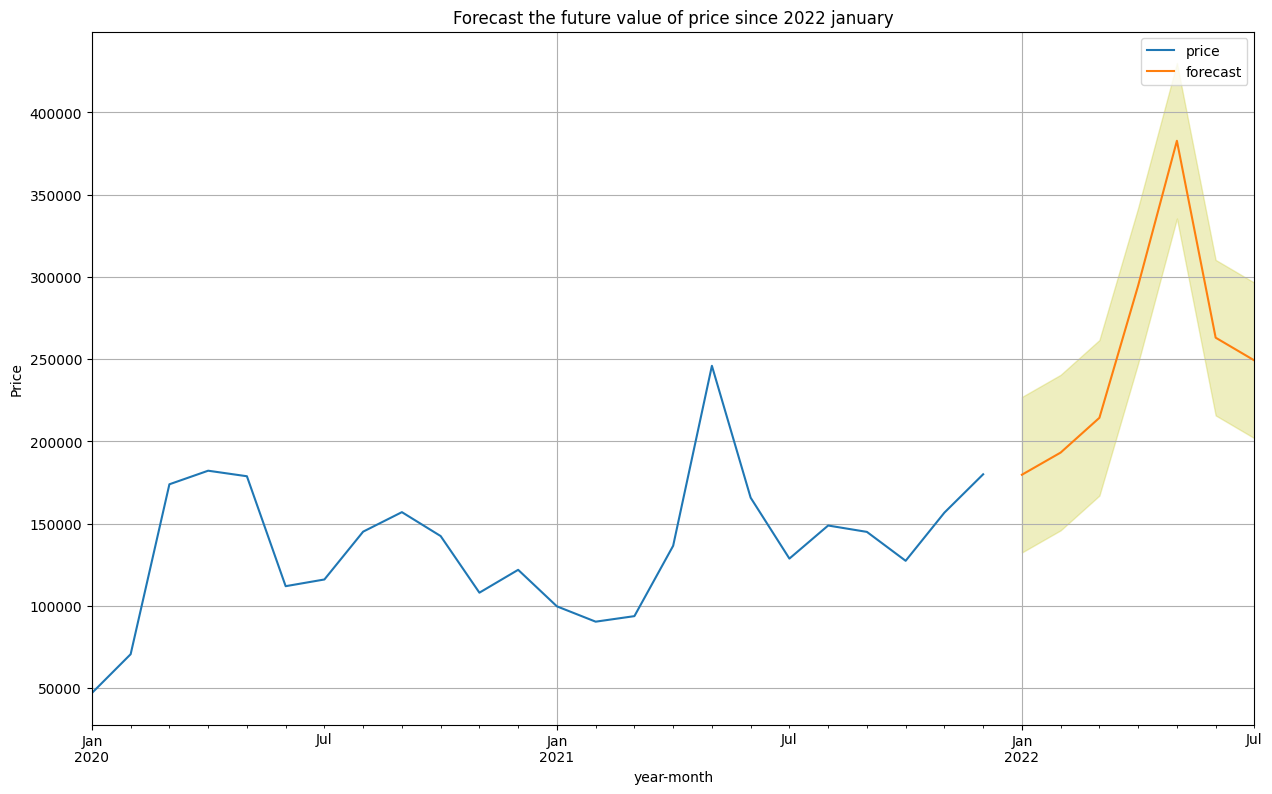

In [93]:
axis = df.plot(label = 'Actual', figsize=(15,9))
pred_df['prediction'].plot(ax= axis, label = 'forecast', alpha =1)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color ='y', alpha = .25)
plt.title("Forecast the future value of price since 2022 january")
axis.set_xlabel('year-month')
axis.set_ylabel('Price')
plt.legend(loc = 'best')
plt.grid()
plt.show()